<h1><b>M5 Forecasting: Final Solution</b></h1>

# **Contents**

<h3> 1. Reading the Data </h3> 

<h3> 2. Define helper functions </h3> 

<h3> 3. Simple Model </h3>

<h3> 4. Hyperparameter Tuning </h3> 

<h3> 5. Building the Final Model </h3> 

<h3> 6. Kaggle Submission Score </h3>

<h3> 7. References </h3>

In [1]:
#import dependencies
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import random 
import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

# 1. Reading the data

In [2]:
df_long = pd.read_pickle('preprocessed_data.pkl')
print(df_long.shape)
df_long.head()

(27471490, 45)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,lag_28,lag_30,...,snap_CA,snap_TX,snap_WI,quarter,week,day_of_month,is_weekend,sell_price,price_shift_t1,price_change_t1
0,14370,1437,3,1,0,0,1069,1,1,1,...,1,1,0,1,1,1,0,8.257812,8.257812,0.0
1,14380,1438,3,1,0,0,1069,0,0,0,...,1,1,0,1,1,1,0,3.970703,3.970703,0.0
2,14390,1439,3,1,0,0,1069,0,0,0,...,1,1,0,1,1,1,0,0.000000,0.000000,0.0
3,14400,1440,3,1,0,0,1069,2,1,3,...,1,1,0,1,1,1,0,4.640625,4.640625,0.0
4,14410,1441,3,1,0,0,1069,1,1,1,...,1,1,0,1,1,1,0,3.080078,3.080078,0.0


In [5]:
df_sales = pd.read_csv('sales_train_evaluation.csv')
df_price = pd.read_csv('sell_prices.csv')
df_cal = pd.read_csv('calendar.csv', parse_dates=['date'])

In [6]:
#basic data manipulation on df_cal and df_price
df_cal["d_"]=df_cal["d"].apply(lambda x: int(x.split("_")[1]))
df_price["id"] = df_price["item_id"] + "_" + df_price["store_id"] + "_evaluation"

# 2. Define helper functions


## 2.1 Compute Weights

In [7]:
level_groupings = {2: ["state_id"], 3: ["store_id"], 4: ["cat_id"], 5: ["dept_id"], 6: ["state_id", "cat_id"], 7: ["state_id", "dept_id"],
                   8: ["store_id", "cat_id"], 9: ["store_id", "dept_id"], 10: ["item_id"], 11: ["item_id", "state_id"]}

def calculate_weightsL12(sales, cal, price, last28):
    ''' Calculate weights for level 12 (Product-Store) series' using the last 28 days sales data '''

    #calculating weights for level 12 : 'item_id, store_id' using last 28 days of train data
    #this loop is repeated 28 times to get the sales revenue of all ids for each of last 28 days 
    #flow of execution : day-> week id-> sell price of ids on the day-> sales revenue of ids for the day
    for day in range(last28[0], last28[1]):
        #get the week id corresponding to the day 
        week_id = int(cal[cal["d_"]==day]["wm_yr_wk"]) 

        #get the week price for each of the items corresponding to the week id   
        week_price = price[price["wm_yr_wk"]==week_id]

        #merge sales with week price on 'id'
        #note: we merge the dataframes using inner join so the id which are present in both dataframes will be retained after merging
        sales = sales.merge(week_price[["sell_price", "id"]], on=["id"], how='inner')

        #create a column which shows the sales revenue for the day
        #sales revenue = sell_price * units_sold 
        sales["sales_revenue_d_" + str(day)] = sales["sell_price"] * sales["d_" + str(day)]

        #drop the sell_price column
        sales.drop(columns=["sell_price"], inplace=True)

    #Sum of sales revenue of each id for last 28 days   1`
    sales_revenue_cols = [x for x in sales.columns if x.find("sales_revenue")==0]
    sales['sales_revenue_alldays'] = sales[sales_revenue_cols].sum(axis=1)

    #Compute weights for each Level 12 Time Series
    sales['weight'] = (1/12)*(sales['sales_revenue_alldays']/sales['sales_revenue_alldays'].sum())

    #Drop the unnecessary columns 
    sales.drop(columns = sales_revenue_cols+['sales_revenue_alldays'], inplace=True)

    return sales

def calculate_weightsALL(sales, levels):
    ''' Calculate weights for series' in rest of the aggregation levels '''
    
    #weights for level 1 : 'all'
    agg = pd.DataFrame(sales[[x for x in sales.columns if x.find("d_") == 0 or x.find("F") == 0]].sum()).transpose() 
    id_cols = ["item_id", "dept_id", "cat_id", "store_id", "state_id"]
    for col in id_cols:
        agg[col] = 'all'
    agg["level"] = 1
    agg["weight"] = 1/12
    column_order = agg.columns

    #weights for the rest of the levels (levels 2-11)
    for level in level_groupings:
        temp_df = sales.groupby(by=level_groupings[level]).sum().reset_index()
        temp_df["level"] = level
        
        for c in column_order:
            if c not in temp_df.columns:
                temp_df[c] = 'all'
                
        agg = agg.append(temp_df[column_order])

    return agg

## 2.2 Compute WRMSSE

In [8]:
def get_day_splits(sales, train_start, train_end, val_start, val_end):
    '''Create lists of days/columns to be selected for train, val and forecast when calculating RMSSE'''
    
    train_days =  [x for x in sales.columns if x.find("d_") == 0 and int(x.split("_")[1]) in range(train_start, train_end+1)] 
    val_days =  [x for x in sales.columns if x.find("d_") == 0 and int(x.split("_")[1]) in range(val_start, val_end+1)]
    forecast_days = [x for x in sales.columns if x.find("F") == 0]
    return train_days, val_days, forecast_days

def RMSSE(ground_truth, forecast, train, n, h):
    ''' Calculates the RMSSE score for all series in the dataframe. '''

    num = ((ground_truth - forecast)**2).sum(axis=1)
    den = 1/(n-1) * ((train[:, 1:] - train[:, :-1]) ** 2).sum(axis=1)  
    rmsse = (1/h * num/den) ** 0.5

    return rmsse

def WRMSSE(sales, agg, train_days, val_days, forecast_days, n, h):
    ''' Calculates the WRMSSE score for the model prediction '''
    
    ground_truth_df = np.array(sales[val_days])
    forecast_df = np.array(sales[forecast_days])
    train_df = np.array(sales[train_days])

    ground_truth_agg_df = np.array(agg[val_days])
    forecast_agg_df = np.array(agg[forecast_days])
    train_agg_df = np.array(agg[train_days])
            
    # calculate rmsse for each series using df[val-days] - df[forecast-days] ->numerator   
    sales["rmsse"] = RMSSE(ground_truth_df, forecast_df, train_df, n, h)
    agg["rmsse"] = RMSSE(ground_truth_agg_df, forecast_agg_df, train_agg_df, n, h)

    sales["wrmsse"] = sales["weight"] * sales["rmsse"]
    agg["wrmsse"] = agg["weight"] * agg["rmsse"]

    wrmsse = sales["wrmsse"].sum() + agg["wrmsse"].sum()
    
    return wrmsse

## 2.3 Evaluate Model Instance

In [9]:
def evaluate_model_instance(model, train_x, train_y, val_x, features, train_start, train_end, df, df_c, df_p, levels, return_df=False):
    ''' Computes the WRMSSE score of the model instance to understand if the model needs to be tuned further or not. '''
    
    print('<<<Training the Model>>>')
    model.fit(train_x[features], train_y)

    catCols = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]
    trainDays = [c for c in df.columns if c.find("d_")==0 and int(c.split("_")[1]) in range(train_start, train_end + 1)] 
    valDays = [c for c in df.columns if c.find("d_")==0 and int(c.split("_")[1]) in range(train_end + 1, train_end + 28 + 1)] 
    df = df[catCols+trainDays+valDays]
    
    print('<<<Generating Forecasts>>>')
    for day in range(1,29):       
        df[f"F{day}"] = model.predict(val_x.loc[val_x["d"]==(train_end+day), features]) 
    
    print('<<<Calculating Weights>>>')
    df = calculate_weightsL12(df, df_c, df_p, (train_end - (28 - 1), train_end+1)) 
    agg_df = calculate_weightsALL(df, levels)

    print('<<<Calculating WRMSSE Score>>>')
    train_days, val_days, forecast_days = get_day_splits(df, train_start, train_end, val_start = train_end + 1, val_end = train_end + 28)
    wrmsse = WRMSSE(df, agg_df, train_days, val_days, forecast_days,  n = ((train_end - train_start)+1) , h = 28)
    print('<<<Model Instance Evaluated>>>')

    #if True, below condition returns the forecast dataframe and WRMSSE score 
    if return_df:
        return df[['id']+forecast_days], wrmsse   
    return wrmsse

## 2.4 Create Data Splits

In [10]:
def get_splits(data, train_start, train_end, return_y_val = False):
    ''' Performs time based split on data and return train and validation sets '''
    
    val_start = train_end + 1
    val_end = train_end + 28
    
    print('Train Period:', train_start, "-", train_end)
    print('Validation Period:', val_start, "-", val_end)
    
    X_train = data[(data['d'] >= train_start) & (data['d'] <= train_end)].drop(columns=['sales']) 
    y_train = data[(data['d'] >= train_start) & (data['d'] <= train_end)]['sales']
    
    X_val = data[(data['d'] >= val_start) & (data['d'] <= val_end)].drop(columns=['sales'])
    
    #if True, returns y_val else not (this option is provided because y_val isn't needed as per the approach we take)
    if return_y_val:
        y_val = data[(data['d'] >= val_start) & (data['d'] <= val_end)]['sales']
        return X_train, y_train, X_val, y_val
    
    return X_train, y_train, X_val

## 2.5 Create Submission File

In [11]:
def get_sub_df(data, train_start, train_end, best_params, features, df_s, df_c, df_p, levels):
    ''' Returns the best model and dataframe containing forecast values '''
    
    #get the train and val set for performing forecast on validation phase days (i.e. 1914 - 1941)
    X_train, y_train, X_val = get_splits(data, train_start, train_end[0], False)
    
    #build a model using best parameter values
    lgb_val = lgb.LGBMRegressor(boosting_type= best_params['boosting_type'], 
                                 objective=best_params['objective'], 
                                 n_jobs= best_params['n_jobs'], 
                                 seed= best_params['seed'], 
                                 n_estimators= best_params['n_estimators'], 
                                 learning_rate= best_params['learning_rate'],
                                 num_leaves = best_params['num_leaves'],
                                 min_child_samples = best_params['min_child_samples'])
    
    #get the forecast dataframe and wrmsse score 
    df_val, wrmsse_val = evaluate_model_instance(lgb_val, X_train, y_train, X_val, features, train_start, train_end[0], df_s, df_c, df_p, levels, return_df=True)
    df_val['id'] = df_val['id'].apply(lambda x: x.replace('_evaluation', '_validation'))
    print('Local WRMSSE on Validation Data:',wrmsse_val)
    print('\n')
    
    #get the train and val set for performing forecast on evaluation phase days (i.e. 1942 - 1969)
    X_train, y_train, X_eval = get_splits(data, train_start, train_end[1], False)
    
    #build another model using best parameter values
    lgb_eval = lgb.LGBMRegressor(boosting_type= best_params['boosting_type'], 
                                 objective=best_params['objective'], 
                                 n_jobs= best_params['n_jobs'], 
                                 seed= best_params['seed'], 
                                 n_estimators= best_params['n_estimators'], 
                                 learning_rate= best_params['learning_rate'],
                                 num_leaves = best_params['num_leaves'],
                                 min_child_samples = best_params['min_child_samples'])
    
    print('<<<Training the Model>>>')
    lgb_eval.fit(X_train[features], y_train)
    
    df_eval = df_s[["id"]]

    print('<<<Generating Forecasts>>>')
    for day in range(1,29):       
        df_eval[f"F{day}"] = lgb_eval.predict(X_eval.loc[X_eval["d"]==(train_end[1]+day), features])
        
    #concat both the forecast dataframes
    submit = pd.concat([df_val, df_eval], axis=0).reset_index(drop=True) 
    print('<<<Submission Dataframe Created>>>')
    
    return lgb_val, lgb_eval, submit

# 3. Simple Model

- Build simple LightGBM Regressor model on data and check the score before heading into hyperparameter tuning.

In [12]:
import lightgbm as lgb
from lightgbm import plot_importance

In [11]:
train_start = 1069
train_end = 1913
X_train, y_train, X_val = get_splits(df_long, train_start, train_end, False)

Train Period: 1069 - 1913
Validation Period: 1914 - 1941


## 3.1 Using base features only

In [12]:
removeFeat = ['d', 'sales', 'date', 'wm_yr_wk']
derivedFeat = ['lag_28', 'lag_30', 'lag_31', 'lag_35', 'lag_42', 'lag_49','lag_56', 'lag_63', 'lag_70', 'lag_77', 
               'rmean_28_7', 'rmean_28_14','rmean_28_28', 'rmean_28_30', 'rmean_28_45', 'rmean_28_60', 'rmean_28_90',
               'rmean_28_120', 'quarter', 'week', 'day_of_month', 'is_weekend', 'price_shift_t1', 'price_change_t1']
features = [c for c in df_long.columns if c not in removeFeat+derivedFeat]

In [14]:
lgb_reg = lgb.LGBMRegressor(importance_type='gain')
wrmsse_reg = evaluate_model_instance(lgb_reg, X_train, y_train, X_val, features, train_start, train_end, df_sales, df_cal, df_price, level_groupings, False)
print('Local WRMSSE on Validation Data:',wrmsse_reg)

<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>
<<<Model Instance Evaluated>>>
Local WRMSSE on Validation Data: 0.9480061768091461


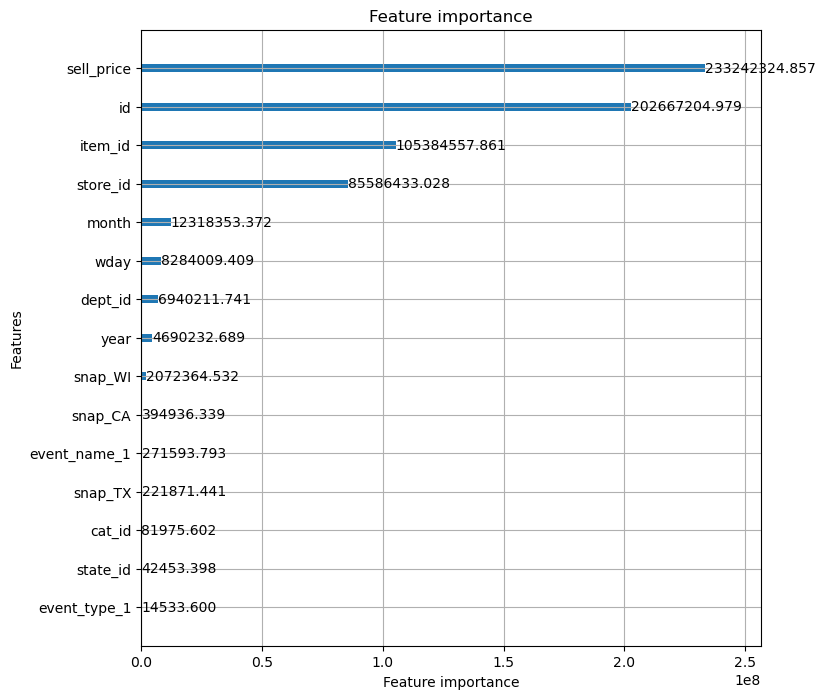

In [16]:
import matplotlib.pyplot as plt
#visualize the feature importance
plot_importance(lgb_reg, figsize=(8,8))
plt.show()

## 3.2 Using base and derived features

In [17]:
removeFeat = ['d', 'sales', 'date', 'wm_yr_wk']
features = [c for c in df_long.columns if c not in removeFeat]

In [20]:
lgb_reg = lgb.LGBMRegressor(importance_type='gain')
wrmsse_reg = evaluate_model_instance(lgb_reg, X_train, y_train, X_val, features, train_start, train_end, df_sales, df_cal, df_price, level_groupings, False)
print('Local WRMSSE on Validation Data:',wrmsse_reg)

<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>
<<<Model Instance Evaluated>>>
Local WRMSSE on Validation Data: 0.6482224550366866


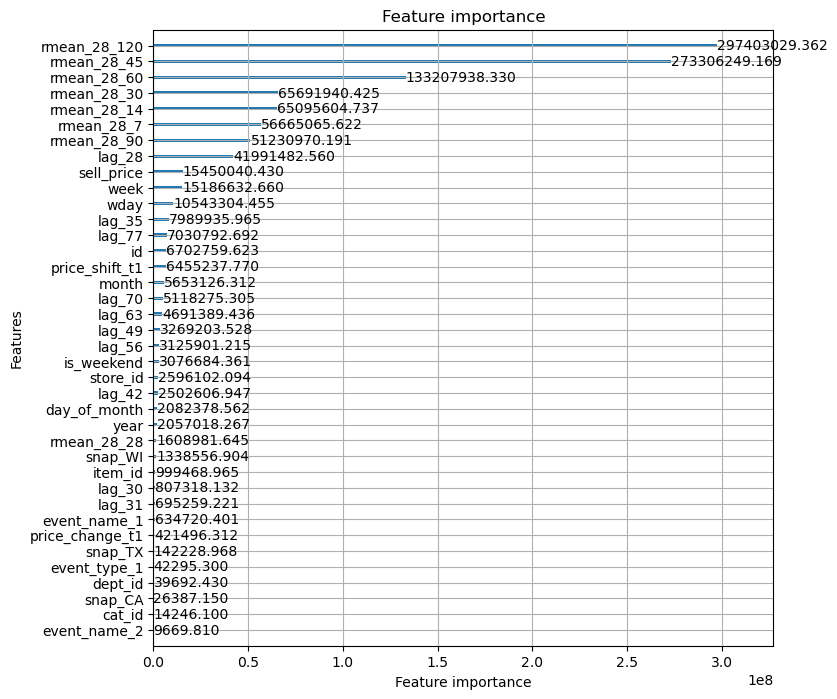

In [21]:
#visualize the feature importance
plot_importance(lgb_reg, figsize=(8,8))
plt.show()

# 4. Hyperparameter Tuning
- Start with a range of values for hyperparameters and check the results
- Tune the range as per the wrmsse score and check the results again
- Repeat the process to get the best set of hyperparameter values

In [11]:
train_start = 1069
train_end = 1913
X_train, y_train, X_val = get_splits(df_long, train_start, train_end, False)

Train Period: 1069 - 1913
Validation Period: 1914 - 1941


In [13]:
removeFeat = ['d', 'sales', 'date', 'wm_yr_wk']
features = [c for c in df_long.columns if c not in removeFeat]

## 4.1 Parameter Tuning Part - 1

In [25]:
#set seed for reproducibility
random.seed(42)

epochs = 10

params = {'learning_rate': (0.01, 0.2),
          'num_leaves': (50, 200),
          'min_child_samples':(100,500)}

selected_params = {'boosting_type':'gbdt',
                   'objective':'poisson', 
                   'n_jobs':-1,
                   'seed':123,
                   'n_estimators':100,
                   'max_depth':-1,
                   'learning_rate':0, 
                   'num_leaves': 0,
                   'min_child_samples': 0}


params_each_epoch = []
wrmsse_each_epoch = []

for i in tqdm(range(1, epochs+1)):
    
    for k,v in list(params.items()):
        if type(v[0])==float:
            selected_params[k] = round(random.uniform(v[0], v[1]),2)
        else:
            selected_params[k] = random.randint(v[0], v[1])
        
    lgb_rand = lgb.LGBMRegressor(boosting_type = selected_params['boosting_type'], 
                                 objective = selected_params['objective'], 
                                 n_jobs = selected_params['n_jobs'], 
                                 seed = selected_params['seed'], 
                                 n_estimators = selected_params['n_estimators'], 
                                 max_depth = selected_params['max_depth'],
                                 learning_rate = selected_params['learning_rate'], 
                                 num_leaves = selected_params['num_leaves'],
                                 min_child_samples = selected_params['min_child_samples'])
        
    wrmsse_rand = evaluate_model_instance(lgb_rand, X_train, y_train, X_val, features, train_start, train_end, 
                                          df_sales, df_cal, df_price, level_groupings, return_df=False)
    
    
    print(f'Epoch {i} Summary:')
    print('Selected Params:', selected_params)
    print('Local WRMSSE Score on Validation Data:', wrmsse_rand)
    print('\n')
    params_each_epoch.append(list(selected_params.items()))
    wrmsse_each_epoch.append(wrmsse_rand)
    
params_each_epoch = list(map(dict, params_each_epoch))

  0%|                                                                                   | 0/10 [00:00<?, ?it/s]

<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 10%|███████▌                                                                   | 1/10 [01:15<11:19, 75.49s/it]

<<<Model Instance Evaluated>>>
Epoch 1 Summary:
Selected Params: {'boosting_type': 'gbdt', 'objective': 'poisson', 'n_jobs': -1, 'seed': 123, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.13, 'num_leaves': 56, 'min_child_samples': 479}
Local WRMSSE Score on Validation Data: 0.6188166096532246


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 20%|███████████████                                                            | 2/10 [02:41<10:54, 81.84s/it]

<<<Model Instance Evaluated>>>
Epoch 2 Summary:
Selected Params: {'boosting_type': 'gbdt', 'objective': 'poisson', 'n_jobs': -1, 'seed': 123, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.06, 'num_leaves': 107, 'min_child_samples': 171}
Local WRMSSE Score on Validation Data: 0.7133416582988494


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 30%|██████████████████████▌                                                    | 3/10 [04:06<09:42, 83.21s/it]

<<<Model Instance Evaluated>>>
Epoch 3 Summary:
Selected Params: {'boosting_type': 'gbdt', 'objective': 'poisson', 'n_jobs': -1, 'seed': 123, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.15, 'num_leaves': 189, 'min_child_samples': 144}
Local WRMSSE Score on Validation Data: 0.5914544482244508


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 40%|██████████████████████████████                                             | 4/10 [05:21<07:59, 79.98s/it]

<<<Model Instance Evaluated>>>
Epoch 4 Summary:
Selected Params: {'boosting_type': 'gbdt', 'objective': 'poisson', 'n_jobs': -1, 'seed': 123, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.12, 'num_leaves': 58, 'min_child_samples': 115}
Local WRMSSE Score on Validation Data: 0.6371158056367844


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 50%|█████████████████████████████████████▌                                     | 5/10 [06:49<06:54, 82.97s/it]

<<<Model Instance Evaluated>>>
Epoch 5 Summary:
Selected Params: {'boosting_type': 'gbdt', 'objective': 'poisson', 'n_jobs': -1, 'seed': 123, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.03, 'num_leaves': 109, 'min_child_samples': 358}
Local WRMSSE Score on Validation Data: 0.9585551120313607


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 60%|█████████████████████████████████████████████                              | 6/10 [08:16<05:37, 84.33s/it]

<<<Model Instance Evaluated>>>
Epoch 6 Summary:
Selected Params: {'boosting_type': 'gbdt', 'objective': 'poisson', 'n_jobs': -1, 'seed': 123, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.12, 'num_leaves': 193, 'min_child_samples': 201}
Local WRMSSE Score on Validation Data: 0.615304781279985


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 70%|████████████████████████████████████████████████████▌                      | 7/10 [09:41<04:12, 84.28s/it]

<<<Model Instance Evaluated>>>
Epoch 7 Summary:
Selected Params: {'boosting_type': 'gbdt', 'objective': 'poisson', 'n_jobs': -1, 'seed': 123, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.15, 'num_leaves': 189, 'min_child_samples': 314}
Local WRMSSE Score on Validation Data: 0.6003757110055955


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 80%|████████████████████████████████████████████████████████████               | 8/10 [11:18<02:56, 88.33s/it]

<<<Model Instance Evaluated>>>
Epoch 8 Summary:
Selected Params: {'boosting_type': 'gbdt', 'objective': 'poisson', 'n_jobs': -1, 'seed': 123, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.05, 'num_leaves': 200, 'min_child_samples': 242}
Local WRMSSE Score on Validation Data: 0.7460157354828882


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [12:29<01:23, 83.06s/it]

<<<Model Instance Evaluated>>>
Epoch 9 Summary:
Selected Params: {'boosting_type': 'gbdt', 'objective': 'poisson', 'n_jobs': -1, 'seed': 123, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.16, 'num_leaves': 51, 'min_child_samples': 488}
Local WRMSSE Score on Validation Data: 0.6192072260424811


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


100%|██████████████████████████████████████████████████████████████████████████| 10/10 [13:52<00:00, 83.21s/it]

<<<Model Instance Evaluated>>>
Epoch 10 Summary:
Selected Params: {'boosting_type': 'gbdt', 'objective': 'poisson', 'n_jobs': -1, 'seed': 123, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.16, 'num_leaves': 158, 'min_child_samples': 274}
Local WRMSSE Score on Validation Data: 0.6013044704596279




In [30]:
results = pd.DataFrame(params_each_epoch)
results['wrmsse'] = wrmsse_each_epoch
results.sort_values('wrmsse',ascending=True, inplace=True)
results

,boosting_type,objective,n_jobs,seed,n_estimators,max_depth,learning_rate,num_leaves,min_child_samples,wrmsse
2,gbdt,poisson,-1,123,100,-1,0.15,189,144,0.591454
6,gbdt,poisson,-1,123,100,-1,0.15,189,314,0.600376
9,gbdt,poisson,-1,123,100,-1,0.16,158,274,0.601304
5,gbdt,poisson,-1,123,100,-1,0.12,193,201,0.615305
0,gbdt,poisson,-1,123,100,-1,0.13,56,479,0.618817
8,gbdt,poisson,-1,123,100,-1,0.16,51,488,0.619207
3,gbdt,poisson,-1,123,100,-1,0.12,58,115,0.637116
1,gbdt,poisson,-1,123,100,-1,0.06,107,171,0.713342
7,gbdt,poisson,-1,123,100,-1,0.05,200,242,0.746016
4,gbdt,poisson,-1,123,100,-1,0.03,109,358,0.958555


## 4.2 Parameter Tuning Part - 2

In [14]:
#set seed for reproducibility
random.seed(42)

epochs = 10

params = {'learning_rate': (0.1, 0.3),
          'num_leaves': (200, 1000),
          'min_child_samples':(100,500)}

selected_params = {'boosting_type':'gbdt',
                   'objective':'poisson', 
                   'n_jobs':-1,
                   'seed':123,
                   'n_estimators':100,
                   'max_depth':-1,
                   'learning_rate':0, 
                   'num_leaves': 0,
                   'min_child_samples': 0}


params_each_epoch = []
wrmsse_each_epoch = []

for i in tqdm(range(1, epochs+1)):
    
    for k,v in list(params.items()):
        if type(v[0])==float:
            selected_params[k] = round(random.uniform(v[0], v[1]),2)
        else:
            selected_params[k] = random.randint(v[0], v[1])
        
    lgb_rand = lgb.LGBMRegressor(boosting_type = selected_params['boosting_type'], 
                                 objective = selected_params['objective'], 
                                 n_jobs = selected_params['n_jobs'], 
                                 seed = selected_params['seed'], 
                                 n_estimators = selected_params['n_estimators'], 
                                 max_depth = selected_params['max_depth'],
                                 learning_rate = selected_params['learning_rate'], 
                                 num_leaves = selected_params['num_leaves'],
                                 min_child_samples = selected_params['min_child_samples'])
        
    wrmsse_rand = evaluate_model_instance(lgb_rand, X_train, y_train, X_val, features, train_start, train_end, 
                                          df_sales, df_cal, df_price, level_groupings, return_df=False)
    
    
    print(f'Epoch {i} Summary:')
    print('Selected Params:', selected_params)
    print('Local WRMSSE Score on Validation Data:', wrmsse_rand)
    print('\n')
    params_each_epoch.append(list(selected_params.items()))
    wrmsse_each_epoch.append(wrmsse_rand)
    
params_each_epoch = list(map(dict, params_each_epoch))

  0%|                                                                                   | 0/10 [00:00<?, ?it/s]

<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 10%|███████▌                                                                   | 1/10 [01:25<12:51, 85.74s/it]

<<<Model Instance Evaluated>>>
Epoch 1 Summary:
Selected Params: {'boosting_type': 'gbdt', 'objective': 'poisson', 'n_jobs': -1, 'seed': 123, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.23, 'num_leaves': 225, 'min_child_samples': 479}
Local WRMSSE Score on Validation Data: 0.5900924638094514


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 20%|███████████████                                                            | 2/10 [02:58<12:00, 90.01s/it]

<<<Model Instance Evaluated>>>
Epoch 2 Summary:
Selected Params: {'boosting_type': 'gbdt', 'objective': 'poisson', 'n_jobs': -1, 'seed': 123, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.16, 'num_leaves': 428, 'min_child_samples': 171}
Local WRMSSE Score on Validation Data: 0.5846528666129969


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 30%|██████████████████████▏                                                   | 3/10 [04:51<11:41, 100.19s/it]

<<<Model Instance Evaluated>>>
Epoch 3 Summary:
Selected Params: {'boosting_type': 'gbdt', 'objective': 'poisson', 'n_jobs': -1, 'seed': 123, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.25, 'num_leaves': 892, 'min_child_samples': 479}
Local WRMSSE Score on Validation Data: 0.6018531664992217


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 40%|██████████████████████████████                                             | 4/10 [06:19<09:33, 95.66s/it]

<<<Model Instance Evaluated>>>
Epoch 4 Summary:
Selected Params: {'boosting_type': 'gbdt', 'objective': 'poisson', 'n_jobs': -1, 'seed': 123, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.28, 'num_leaves': 289, 'min_child_samples': 402}
Local WRMSSE Score on Validation Data: 0.5736728826667026


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 50%|█████████████████████████████████████▌                                     | 5/10 [07:44<07:38, 91.74s/it]

<<<Model Instance Evaluated>>>
Epoch 5 Summary:
Selected Params: {'boosting_type': 'gbdt', 'objective': 'poisson', 'n_jobs': -1, 'seed': 123, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.18, 'num_leaves': 230, 'min_child_samples': 147}
Local WRMSSE Score on Validation Data: 0.5866829426910679


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 60%|█████████████████████████████████████████████                              | 6/10 [09:27<06:21, 95.45s/it]

<<<Model Instance Evaluated>>>
Epoch 6 Summary:
Selected Params: {'boosting_type': 'gbdt', 'objective': 'poisson', 'n_jobs': -1, 'seed': 123, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.14, 'num_leaves': 717, 'min_child_samples': 408}
Local WRMSSE Score on Validation Data: 0.5798958866904244


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 70%|████████████████████████████████████████████████████▌                      | 7/10 [11:02<04:45, 95.31s/it]

<<<Model Instance Evaluated>>>
Epoch 7 Summary:
Selected Params: {'boosting_type': 'gbdt', 'objective': 'poisson', 'n_jobs': -1, 'seed': 123, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.11, 'num_leaves': 403, 'min_child_samples': 466}
Local WRMSSE Score on Validation Data: 0.6216291410871244


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 80%|████████████████████████████████████████████████████████████               | 8/10 [12:46<03:16, 98.23s/it]

<<<Model Instance Evaluated>>>
Epoch 8 Summary:
Selected Params: {'boosting_type': 'gbdt', 'objective': 'poisson', 'n_jobs': -1, 'seed': 123, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.23, 'num_leaves': 758, 'min_child_samples': 314}
Local WRMSSE Score on Validation Data: 0.5960998202195598


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 90%|██████████████████████████████████████████████████████████████████▌       | 9/10 [14:30<01:40, 100.05s/it]

<<<Model Instance Evaluated>>>
Epoch 9 Summary:
Selected Params: {'boosting_type': 'gbdt', 'objective': 'poisson', 'n_jobs': -1, 'seed': 123, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.14, 'num_leaves': 803, 'min_child_samples': 242}
Local WRMSSE Score on Validation Data: 0.5907610437791956


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


100%|██████████████████████████████████████████████████████████████████████████| 10/10 [15:53<00:00, 95.39s/it]

<<<Model Instance Evaluated>>>
Epoch 10 Summary:
Selected Params: {'boosting_type': 'gbdt', 'objective': 'poisson', 'n_jobs': -1, 'seed': 123, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.26, 'num_leaves': 206, 'min_child_samples': 488}
Local WRMSSE Score on Validation Data: 0.5866768994099802




In [15]:
results = pd.DataFrame(params_each_epoch)
results['wrmsse'] = wrmsse_each_epoch
results.sort_values('wrmsse',ascending=True, inplace=True)
results

,boosting_type,objective,n_jobs,seed,n_estimators,max_depth,learning_rate,num_leaves,min_child_samples,wrmsse
3,gbdt,poisson,-1,123,100,-1,0.28,289,402,0.573673
5,gbdt,poisson,-1,123,100,-1,0.14,717,408,0.579896
1,gbdt,poisson,-1,123,100,-1,0.16,428,171,0.584653
9,gbdt,poisson,-1,123,100,-1,0.26,206,488,0.586677
4,gbdt,poisson,-1,123,100,-1,0.18,230,147,0.586683
0,gbdt,poisson,-1,123,100,-1,0.23,225,479,0.590092
8,gbdt,poisson,-1,123,100,-1,0.14,803,242,0.590761
7,gbdt,poisson,-1,123,100,-1,0.23,758,314,0.596100
2,gbdt,poisson,-1,123,100,-1,0.25,892,479,0.601853
6,gbdt,poisson,-1,123,100,-1,0.11,403,466,0.621629


## 4.3 Parameter Tuning Part - 3

In [31]:
best_params = results.iloc[0,:-1].to_dict()
best_params

{'boosting_type': 'gbdt',
 'objective': 'poisson',
 'n_jobs': -1,
 'seed': 123,
 'n_estimators': 100,
 'max_depth': -1,
 'learning_rate': 0.28,
 'num_leaves': 289,
 'min_child_samples': 402}

In [25]:
n_est = [50, 75, 80, 90, 95, 105, 110, 125]

for i in tqdm(range(1,len(n_est)+1)):
    best_params['n_estimators'] = n_est[i-1]
    
    lgb_rand = lgb.LGBMRegressor(boosting_type = best_params['boosting_type'], 
                                 objective = best_params['objective'], 
                                 n_jobs = best_params['n_jobs'], 
                                 seed = best_params['seed'], 
                                 n_estimators = best_params['n_estimators'], 
                                 max_depth = best_params['max_depth'],
                                 learning_rate = best_params['learning_rate'], 
                                 num_leaves = best_params['num_leaves'],
                                 min_child_samples = best_params['min_child_samples'])
        
    wrmsse_rand = evaluate_model_instance(lgb_rand, X_train, y_train, X_val, features, train_start, train_end, 
                                          df_sales, df_cal, df_price, level_groupings, return_df=False)
    
    print(f'Epoch {i} Summary:')
    print('Selected Number of Estimators:', best_params['n_estimators'])
    print('Local WRMSSE Score on Validation Data:', wrmsse_rand)
    print('\n')

  0%|                                                                                    | 0/8 [00:00<?, ?it/s]

<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 12%|█████████▌                                                                  | 1/8 [00:57<06:44, 57.79s/it]

<<<Model Instance Evaluated>>>
Epoch 1 Summary:
Selected Number of Estimators: 50
Local WRMSSE Score on Validation Data: 0.599588256173172


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 25%|███████████████████                                                         | 2/8 [02:10<06:38, 66.43s/it]

<<<Model Instance Evaluated>>>
Epoch 2 Summary:
Selected Number of Estimators: 75
Local WRMSSE Score on Validation Data: 0.5801404041048497


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 38%|████████████████████████████▌                                               | 3/8 [03:23<05:48, 69.71s/it]

<<<Model Instance Evaluated>>>
Epoch 3 Summary:
Selected Number of Estimators: 80
Local WRMSSE Score on Validation Data: 0.5730982630380483


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 50%|██████████████████████████████████████                                      | 4/8 [04:45<04:57, 74.27s/it]

<<<Model Instance Evaluated>>>
Epoch 4 Summary:
Selected Number of Estimators: 90
Local WRMSSE Score on Validation Data: 0.5717035288102512


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 62%|███████████████████████████████████████████████▌                            | 5/8 [06:09<03:53, 77.87s/it]

<<<Model Instance Evaluated>>>
Epoch 5 Summary:
Selected Number of Estimators: 95
Local WRMSSE Score on Validation Data: 0.572646321203648


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 75%|█████████████████████████████████████████████████████████                   | 6/8 [07:40<02:44, 82.32s/it]

<<<Model Instance Evaluated>>>
Epoch 6 Summary:
Selected Number of Estimators: 105
Local WRMSSE Score on Validation Data: 0.5735717998035524


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


 88%|██████████████████████████████████████████████████████████████████▌         | 7/8 [09:13<01:25, 85.84s/it]

<<<Model Instance Evaluated>>>
Epoch 7 Summary:
Selected Number of Estimators: 110
Local WRMSSE Score on Validation Data: 0.5754420361046892


<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>


100%|████████████████████████████████████████████████████████████████████████████| 8/8 [10:53<00:00, 81.75s/it]

<<<Model Instance Evaluated>>>
Epoch 8 Summary:
Selected Number of Estimators: 125
Local WRMSSE Score on Validation Data: 0.5730078309258472




## 5. Building Final Model

In [33]:
best_params['n_estimators'] = 90
best_params

{'boosting_type': 'gbdt',
 'objective': 'poisson',
 'n_jobs': -1,
 'seed': 123,
 'n_estimators': 90,
 'max_depth': -1,
 'learning_rate': 0.28,
 'num_leaves': 289,
 'min_child_samples': 402}

In [15]:
removeFeat = ['d', 'sales', 'date', 'wm_yr_wk']
features = [c for c in df_long.columns if c not in removeFeat]

In [16]:
train_start = 1069
train_end = (1913, 1941)
model_val, model_eval, submit = get_sub_df(df_long, train_start, train_end, best_params, features, df_sales, df_cal, df_price, level_groupings)

Train Period: 1069 - 1913
Validation Period: 1914 - 1941
<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Calculating Weights>>>
<<<Calculating WRMSSE Score>>>
<<<Model Instance Evaluated>>>
Local WRMSSE on Validation Data: 0.5717035288102503


Train Period: 1069 - 1941
Validation Period: 1942 - 1969
<<<Training the Model>>>
<<<Generating Forecasts>>>
<<<Submission Dataframe Created>>>


In [22]:
model_val, model_eval

(LGBMRegressor(learning_rate=0.28, min_child_samples=402, n_estimators=90,
               num_leaves=289, objective='poisson', seed=123),
 LGBMRegressor(learning_rate=0.28, min_child_samples=402, n_estimators=90,
               num_leaves=289, objective='poisson', seed=123))

In [ ]:
pickle.dump(model_val, open("model_val.pkl", "wb")) 
pickle.dump(model_eval, open("model_eval.pkl", "wb")) 

In [41]:
submit.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.995624,0.788201,0.738455,0.704260,0.799978,1.024613,1.107099,0.785542,0.822707,...,0.866449,1.271255,1.165837,0.907779,0.835369,0.802204,0.873191,0.918685,1.239383,1.256659
1,HOBBIES_1_002_CA_1_validation,0.424184,0.362029,0.358571,0.332996,0.370462,0.488325,0.448928,0.317507,0.292728,...,0.245980,0.305024,0.287455,0.200119,0.193856,0.201883,0.181976,0.200542,0.238245,0.216938
2,HOBBIES_1_003_CA_1_validation,0.544155,0.485894,0.478982,0.479146,0.577916,0.746256,0.783448,0.525440,0.488071,...,0.488957,0.658628,0.730954,0.610179,0.537741,0.536026,0.469846,0.584326,0.745750,0.745196
3,HOBBIES_1_004_CA_1_validation,2.060919,1.594390,1.533142,1.502108,1.893367,2.070375,2.422500,1.741638,1.660692,...,1.829608,2.116257,2.526139,1.898293,1.588445,1.496463,1.555302,1.947845,2.660915,2.667951
4,HOBBIES_1_005_CA_1_validation,1.004134,0.823457,0.888685,1.048426,1.091341,1.383952,1.694218,1.197476,1.157467,...,1.101868,1.314824,1.454438,1.017177,0.892443,0.900822,0.931148,1.076327,1.372470,1.570811


In [39]:
submit.to_csv('final_submission.csv', index=False)

# 6. Kaggle Submission Score

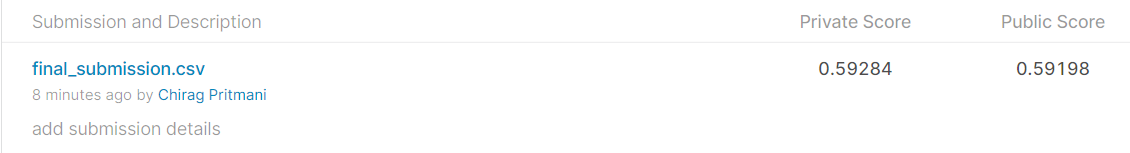

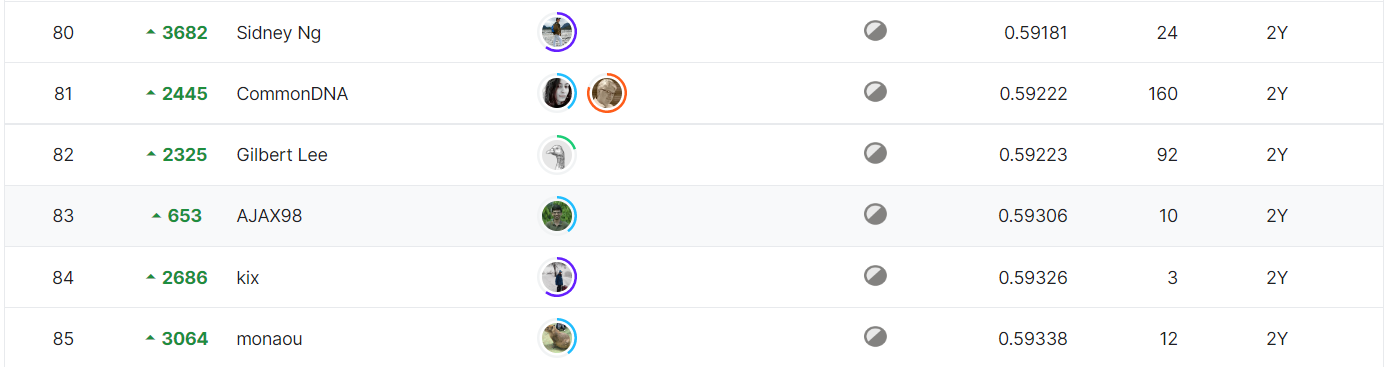

- The submission score on Private Leaderboard ranks us 83rd on the list out of 5582 contestants which is under ~1.5% of submissions.
- There's a difference of ~0.02 in Public Score and our Local WRMSSE Score, which means our custom made WRMSSE calculation is pretty accurate.

# 7. References
- https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5